In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import plotly.express as px
import mplcyberpunk

from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.layers import LSTM ,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from keras.regularizers import L1L2

from numpy.random import seed


In [2]:

seed(42)
tf.random.set_seed(42)

In [3]:
sales_tot = pd.read_csv('./data/sales_full.csv', index_col=0)
sales_tot.head()

,year,week,Total,weeks
0,2019,1,37640.0,1
1,2019,2,19520.0,2
2,2019,6,1270.0,3
3,2019,7,2700.0,4
4,2019,10,3560.0,5


**When using the sigmoid (default) or tanh activation functions, LSTMs are sensitive to the scale of the input data. Rescaling data to the 0-to-1 range, also known as normalizing, is a recommended technique. Using the MinMaxScaler preprocessing class from the scikit-learn package, we can quickly normalize the dataset.**

In [4]:
# sales = sales_tot.groupby(by = ['date'])['Total'].sum()
# sales = pd.DataFrame(sales)
# sales.reset_index(inplace = True)
# sales.head()

In [5]:
# #weekley group by based on year and week
# weekley_groupby = sales_tot.groupby(by =['year','week']).sum()
# weekley_groupby = pd.DataFrame(weekley_groupby)
# weekley_groupby.reset_index(inplace=True)
# weekley_groupby.drop(['month','days'], axis = 1, inplace = True)
# weekley_groupby.head(5)

In [6]:
# # adding a weeks col which contains continous week numbers 
# weekley_groupby['weeks'] = np.arange(len(weekley_groupby))
# weekley_groupby['weeks'] = weekley_groupby['weeks'] +1 
# weekley_groupby.head()

In [4]:
sales_tot = sales_tot.drop(['year','week','weeks'], axis = 1)
sales_ = sales_tot.copy()

In [5]:
sales_.head()

,Total
0,37640.0
1,19520.0
2,1270.0
3,2700.0
4,3560.0


In [21]:
len(sales_)

139

In [22]:
window_size = 8
#tot = sales['Total].tolist()
i = 0
moving_averages = []
while i < len(sales_['Total']) - window_size + 1:
    this_window = sales_['Total'][i : i + window_size]
    window_average = sum(this_window) / window_size
    moving_averages.append(window_average)
    i += 1

#print(moving_averages)

In [23]:
sales = pd.DataFrame(moving_averages, columns=['Total'])
sales.head()
len(sales)

132

In [24]:
# normalize the dataset
scaler = MinMaxScaler()
sales_norm = scaler.fit_transform(sales.Total.values.reshape(-1, 1))

In [25]:
sales_norm = sales_norm.flatten().tolist()

In [26]:
sales['sales_norm'] = sales_norm

In [27]:

sales = sales.drop(['Total'],axis = 1)

In [28]:
#adding lag to the sales for multistep forecasting
def lags(dataframe, lags):
    for lag in range(1,lags):
        col_name = 'lag_' +str(lag)
        dataframe[col_name] = dataframe['sales_norm'].shift(lag)

    #drop null val
    dataframe = dataframe.dropna().reset_index(drop = True)
    return dataframe

In [29]:
sales = lags(sales,6)
sales


,sales_norm,lag_1,lag_2,lag_3,lag_4,lag_5
0,0.056114,0.054119,0.044229,0.042713,0.008367,0.044518
1,0.072635,0.056114,0.054119,0.044229,0.042713,0.008367
2,0.121357,0.072635,0.056114,0.054119,0.044229,0.042713
3,0.108576,0.121357,0.072635,0.056114,0.054119,0.044229
4,0.106242,0.108576,0.121357,0.072635,0.056114,0.054119
...,...,...,...,...,...,...
122,0.508997,0.517887,0.521675,0.505807,0.502158,0.549952
123,0.428027,0.508997,0.517887,0.521675,0.505807,0.502158
124,0.469437,0.428027,0.508997,0.517887,0.521675,0.505807
125,0.459240,0.469437,0.428027,0.508997,0.517887,0.521675


In [30]:
# tain and test dataset
def split_train_test(dataframe,trainsize):
    """ This function splits the dataframe in to train and test sets and converts in to LSTM readable format
    It needs 2 input: 
        1. Dataframe to split the dta into train and test
        2. trainsize in percentage ratio.
            eg: if you want 80% of the data as training then plug in 0.8"""

    train = dataframe[: int(len(dataframe)*trainsize)].values
    test =  dataframe[int(len(dataframe)*trainsize):].values
    X_train = train[:, 1:]
    y_train = train[:, 0:1]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = test[:, 1:]
    y_test = test[:, 0:1]
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    return X_train, y_train, X_test, y_test

In [31]:
X_train, y_train, X_test, y_test = split_train_test(lags(sales,6), 0.9)

In [32]:
X_train.shape

(109, 1, 5)

In [21]:
# building an LSTM model

K.clear_session()
#tf.random.set_seed(89)

In [22]:
model = Sequential()
model.add(Bidirectional(LSTM(64, activation = 'tanh', input_shape = ( X_train.shape[1], X_train.shape[2]), return_sequences=True)))
#model.add(Bidirectional(LSTM(512, activation = 'tanh', return_sequences = True)))
#model.add(Bidirectional(LSTM(256,activation = 'tanh', return_sequences = True)))
#model.add(Bidirectional(LSTM(128, activation = 'tanh', return_sequences = True)))
#model.add(Bidirectional(LSTM(64, activation = 'tanh', return_sequences = True)))
model.add(Bidirectional(LSTM(32, activation = 'tanh', return_sequences = False)))
model.add(Dropout(0.5))
#model.add(Dense(1024, activation = 'tanh'))
#model.add(Dense(512, activation = 'tanh'))#256,
#model.add(Dense(100, activation = 'tanh'))#256,128
model.add(Dense(50, activation = 'tanh'))
model.add(Dense(y_train.shape[1]))

In [23]:
model.compile(optimizer='adam', 
                loss='mse')#metrics=['mse']


#model.summary()

In [24]:
cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                    min_delta=0.01,
                                    patience=499,
                                    verbose=1,
                                    mode="min",
                                    baseline=None,
                                    restore_best_weights=False)

In [25]:
history = model.fit(X_train,y_train, 
                    epochs = 500, 
                    batch_size = 10, 
                    validation_split=0.2, 
                    verbose = 1,
                    callbacks=[cb],
                    shuffle= True)
#np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32')

Epoch 1/500
9/9 [==============================] - 10s 170ms/step - loss: 0.1420 - val_loss: 0.1001
Epoch 2/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0551 - val_loss: 0.0058
Epoch 3/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0368 - val_loss: 0.0094
Epoch 4/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0259 - val_loss: 0.0080
Epoch 5/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0214 - val_loss: 0.0085
Epoch 6/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0152 - val_loss: 0.0057
Epoch 7/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0152 - val_loss: 0.0065
Epoch 8/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0148 - val_loss: 0.0055
Epoch 9/500
9/9 [==============================] - 0s 14ms/step - loss: 0.0160 - val_loss: 0.0071
Epoch 10/500
9/9 [==============================] - 0s 13ms/step - loss: 0.0110 - val_loss: 0.0042
Epoch 11/500
9/9 

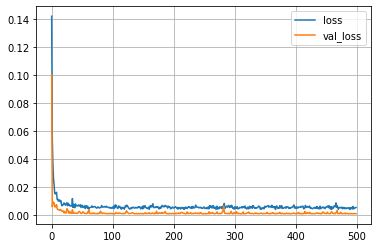

Model Evalution Score
1/1 [==============================] - 0s 18ms/step - loss: 0.0017
0.001652174862101674


In [26]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca() # set the y range to [0,1]
plt.show()
print('Model Evalution Score')
print(model.evaluate(X_test, y_test))

In [27]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [28]:
#X_train, y_train, X_test, y_test = split_train_test(lags(sales, 11), 0.8)

In [29]:
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

In [30]:
type(trainPredict)

numpy.ndarray

In [31]:
sale_week = np.concatenate((y_train , y_test), axis = 0)
sale_pred = np.concatenate((trainPredict , testPredict), axis = 0)

In [32]:
trainScore = math.sqrt(mean_squared_error(y_train[:,0], trainPredict[:,0]))
trainScore

5585.903740340584

In [33]:
testScore = math.sqrt(mean_squared_error(y_test[:,0], testPredict[:,0]))
testScore

4124.319685215934

In [34]:
train_r2 = r2_score(y_train[:,0], trainPredict[:,0])
train_r2

0.9598675413217433

In [35]:
test_r2 = r2_score(y_test[:,0], testPredict[:,0])
test_r2

0.12662773267160754

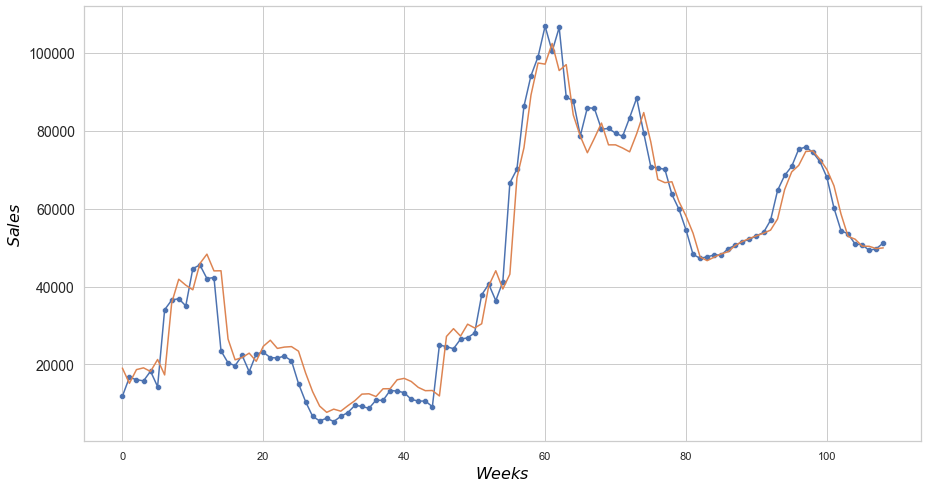

In [36]:
sns.set_theme(context='notebook',
    style="whitegrid",
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None)
fig_dims = (15,8 )
fig, ax = plt.subplots(figsize=fig_dims)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

sns.lineplot(x = np.arange(len(trainPredict)), y = y_train[:,0].tolist() , ax = ax)  #sales[: int(len(sales)*0.8)].sales_norm
sns.scatterplot(x = np.arange(len(trainPredict)), y = y_train[:,0].tolist(), markers= '*', ax = ax )
sns.lineplot(x = np.arange(len(trainPredict)), y =trainPredict[:,0].tolist() , ax = ax)
plt.xlabel(r'$Weeks$', fontdict = font)
plt.ylabel(r'$Sales$ ', fontdict = font)
plt.yticks(fontsize = 14)
plt.show()

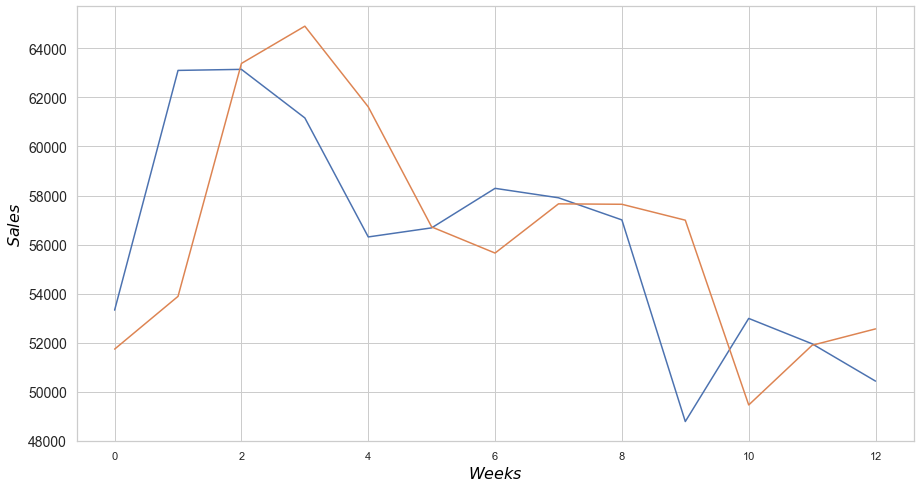

In [37]:
sns.set_theme(context='notebook',
    style="whitegrid",
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None)
fig_dims = (15,8 )
fig, ax = plt.subplots(figsize=fig_dims)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
sns.lineplot(x = np.arange(len(testPredict)), y = y_test[:,0].tolist() , ax = ax)  #sales[: int(len(sales)*0.8)].sales_norm
sns.lineplot(x = np.arange(len(testPredict)), y =testPredict[:,0].tolist() , ax = ax)
plt.xlabel(r'$Weeks$', fontdict = font)
plt.ylabel(r'$Sales$ ', fontdict = font)
plt.yticks(fontsize = 14)
plt.show()

In [38]:
#model.save(r".\models\model_final.h5")


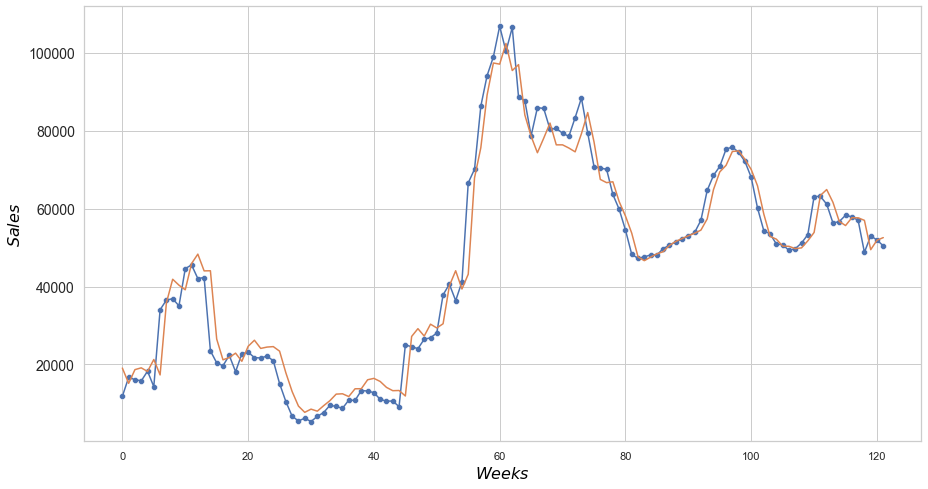

In [39]:
sns.set_theme(context='notebook',
    style="whitegrid",
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None)
fig_dims = (15,8 )
fig, ax = plt.subplots(figsize=fig_dims)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
sns.lineplot(x = np.arange(len(sale_week)), y = sale_week[:,0].tolist() , ax = ax)
sns.scatterplot(x = np.arange(len(sale_week)), y = sale_week[:,0].tolist(), markers= '*', ax = ax )
sns.lineplot(x = np.arange(len(sale_pred)), y =sale_pred[:,0].tolist() , ax = ax)
plt.xlabel(r'$Weeks$', fontdict = font)
plt.ylabel(r'$Sales$ ', fontdict = font)
plt.yticks(fontsize = 14)
plt.show()

In [40]:
sale_week = np.concatenate((y_train , y_test), axis = 0)[:,0].tolist()
sale_pred = np.concatenate((trainPredict , testPredict), axis = 0)[:,0].tolist()

result = pd.DataFrame({'sales': sale_week,'sales_pred': sale_pred})
result.head()

,sales,sales_pred
0,11842.25000,19077.253906
1,16687.09375,15163.912109
2,16121.09375,18684.783203
3,15789.59375,19141.810547
4,18271.46875,18210.673828


In [6]:
result.to_csv('./data/results_1.csv')

NameError: name 'result' is not defined

In [7]:
res = pd.read_csv('./data/results_1.csv', index_col=0)
res.head()

,sales,sales_pred
0,11842.25000,19077.253906
1,16687.09375,15163.912109
2,16121.09375,18684.783203
3,15789.59375,19141.810547
4,18271.46875,18210.673828


In [8]:
len(res)

122

In [9]:
week = np.arange(len(res['sales']))
res['week'] = week

In [10]:
res.to_csv('./data/results_week.csv')

In [11]:
len(res.sales[:109])

109

In [12]:
res.sales[:109]

0      11842.25000
1      16687.09375
2      16121.09375
3      15789.59375
4      18271.46875
          ...     
104    50909.23125
105    50742.86875
106    49288.38125
107    49717.78125
108    51178.28125
Name: sales, Length: 109, dtype: float64

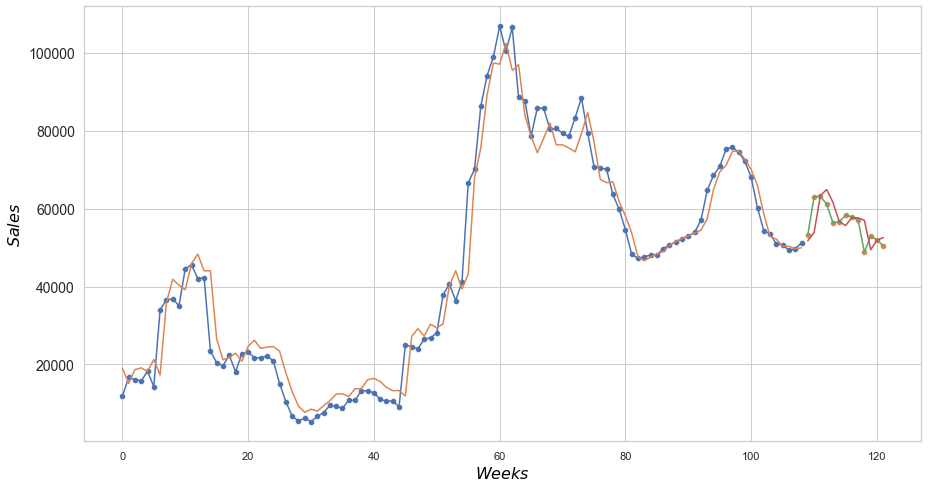

In [13]:
sns.set_theme(context='notebook',
    style="whitegrid",
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None)
fig_dims = (15,8 )
fig, ax = plt.subplots(figsize=fig_dims)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
sns.lineplot(x = res.week[:109], y = res.sales[:109] , ax = ax)
sns.scatterplot(x = res.week[:109], y = res.sales[:109] , ax = ax, markers= '*')
sns.lineplot(x = res.week[:109], y = res.sales_pred[:109] , ax = ax)

sns.lineplot(x = res.week[109:], y = res.sales[109:] , ax = ax)
sns.scatterplot(x = res.week[109:], y = res.sales[109:] , ax = ax, markers= '*')
sns.lineplot(x = res.week[109:], y = res.sales_pred[109:] , ax = ax)


plt.xlabel(r'$Weeks$', fontdict = font)
plt.ylabel(r'$Sales$ ', fontdict = font)
plt.yticks(fontsize = 14)
plt.show()

In [14]:
pred = pd.read_csv('./data/results_week.csv', index_col=0)
pred.head()

,sales,sales_pred,week
0,11842.25000,19077.253906,0
1,16687.09375,15163.912109,1
2,16121.09375,18684.783203,2
3,15789.59375,19141.810547,3
4,18271.46875,18210.673828,4


In [25]:
forecast = pd.read_csv('./data/forecast_12weeks.csv')
forecast.head()


,week,forecast1,forecast2,forecast3,forecast4,forecast5,forecast6,forecast7,forecast8,forecast9,forecast10,forecast11
0,122,65533.32031,65533.32031,65533.32031,67245.25781,67245.25781,65533.32031,64779.43750,59932.05078,56269.35547,54711.09375,55741.84766
1,123,51018.08594,51018.08594,51018.08594,47075.02344,47075.02344,51018.08594,52534.34375,55665.55469,52812.43750,50361.76172,49628.40625
2,124,53170.78125,53170.78125,53170.78125,41686.74219,41686.74219,53170.78125,55592.81641,54305.84375,56218.26172,53385.60156,51326.28906
3,125,45013.18750,45013.18750,45013.18750,43845.69141,43845.69141,45013.18750,55286.97656,55419.84766,54001.72266,55639.18359,53412.88672
4,126,45692.15234,45692.15234,45692.15234,54642.11328,54642.11328,45692.15234,53752.56641,54473.95313,54372.43359,53226.25000,55093.32031


In [80]:
#week = np.arange(len(pred['Total']))
#pred['week'] = week

In [26]:
avg_forecast = forecast[['forecast1',
'forecast2','forecast3','forecast4','forecast5',
'forecast6','forecast7','forecast8','forecast9',
'forecast10','forecast11']].mean(axis  =1)

In [27]:
forecast['mean'] = avg_forecast

In [28]:
forecast['std'] = forecast[['forecast1',
'forecast2','forecast3','forecast4','forecast5',
'forecast6','forecast7','forecast8','forecast9',
'forecast10','forecast11']].std(axis  =1)

In [29]:
forecast.to_csv('./forecast_data/forecast_avg.csv')

In [31]:
forecast = pd.read_csv('./forecast_data/forecast_avg.csv')

In [32]:
forecast.head()

,Unnamed: 0,week,forecast1,forecast2,forecast3,forecast4,forecast5,forecast6,forecast7,forecast8,forecast9,forecast10,forecast11,mean,std
0,0,122,65533.32031,65533.32031,65533.32031,67245.25781,67245.25781,65533.32031,64779.43750,59932.05078,56269.35547,54711.09375,55741.84766,62550.689275,4886.323994
1,1,123,51018.08594,51018.08594,51018.08594,47075.02344,47075.02344,51018.08594,52534.34375,55665.55469,52812.43750,50361.76172,49628.40625,50838.626777,2453.994589
2,2,124,53170.78125,53170.78125,53170.78125,41686.74219,41686.74219,53170.78125,55592.81641,54305.84375,56218.26172,53385.60156,51326.28906,51535.038353,5042.064664
3,3,125,45013.18750,45013.18750,45013.18750,43845.69141,43845.69141,45013.18750,55286.97656,55419.84766,54001.72266,55639.18359,53412.88672,49227.704546,5342.772899
4,4,126,45692.15234,45692.15234,45692.15234,54642.11328,54642.11328,45692.15234,53752.56641,54473.95313,54372.43359,53226.25000,55093.32031,51179.214487,4377.206986


In [85]:
#pred.to_csv('./data/forecast_week.csv')

In [88]:
pred.tail(15)

,sales,sales_pred,week
107,49717.78125,49741.105469,107
108,51178.28125,49929.242188,108
109,53330.94375,51741.816406,109
110,63099.53125,53892.339844,110
111,63141.83125,63383.187500,111
112,61162.86250,64901.390625,112
113,56313.41250,61613.562500,113
114,56683.65000,56720.687500,114
115,58293.72500,55656.546875,115
116,57909.41250,57661.757812,116


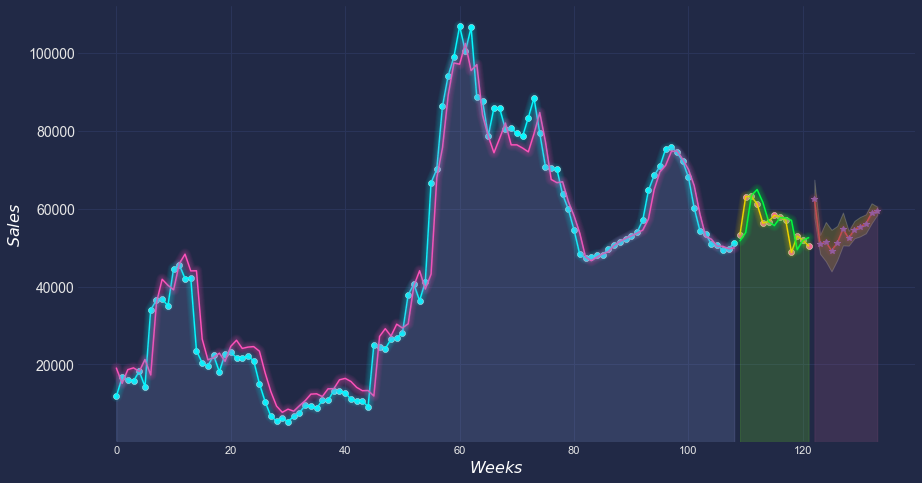

In [33]:
fig_dims = (15,8 )
fig, ax = plt.subplots(figsize=fig_dims)
plt.style.use("dark_background")
plt.style.use("cyberpunk")

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16,
        }

sns.lineplot(x = res.week[:109], y = res.sales[:109] , ax = ax)
sns.scatterplot(x = res.week[:109], y = res.sales[:109] , ax = ax, markers= '*')
sns.lineplot(x = res.week[:109], y = res.sales_pred[:109] , ax = ax)

sns.lineplot(x = res.week[109:122], y = res.sales[109:122] , ax = ax)
sns.scatterplot(x = res.week[109:122], y = res.sales[109:122] , ax = ax, markers= '*')
sns.lineplot(x = res.week[109:122], y = res.sales_pred[109:122] , ax = ax)

#sns.lineplot(x = forecast['week'], y = forecast['mean'] , ax = ax)
#sns.scatterplot(x = forecast['week'], y = forecast['mean'] , ax = ax, markers= '*')

ax.plot(forecast['week'], forecast['mean'], '-')
ax.fill_between(forecast['week'], forecast['mean'] - forecast['std'], forecast['mean'] + forecast['std'], alpha=0.2)
ax.plot(forecast['week'], forecast['mean'], '*')

plt.xlabel(r'$Weeks$', fontdict = font)
plt.ylabel(r'$Sales$ ', fontdict = font)
plt.yticks(fontsize = 14)

mplcyberpunk.add_glow_effects()
plt.show()

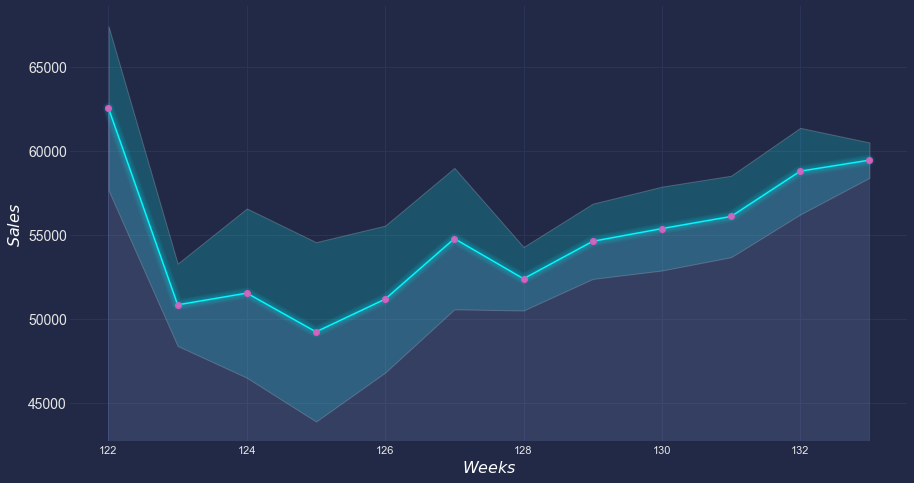

In [34]:
fig_dims = (15,8 )
fig, ax = plt.subplots(figsize=fig_dims)
plt.style.use("dark_background")
plt.style.use("cyberpunk")

font = {'family': 'serif',
        'color':  'white',
        'weight': 'normal',
        'size': 16,
        }

ax.plot(forecast['week'], forecast['mean'], '-')
ax.fill_between(forecast['week'], forecast['mean'] - forecast['std'], forecast['mean'] + forecast['std'], alpha=0.2)
ax.plot(forecast['week'], forecast['mean'], 'o')
plt.xlabel(r'$Weeks$', fontdict = font)
plt.ylabel(r'$Sales$ ', fontdict = font)
plt.yticks(fontsize = 14)
mplcyberpunk.add_glow_effects()
plt.show()

In [35]:
#forecast['week'], forecast['mean'], '-'
import plotly.express as px
import plotly.io as pio
#pio.renderers.default = "vscode"
pio.renderers.default = "notebook_connected"
#fig = px.scatter(forecast, x  ='week', y = 'mean')

fig = px.line(forecast, x  ='week', y = 'mean',  markers = True)
#fig = ax.fill_between(forecast['week'], forecast['mean'] - forecast['std'], forecast['mean'] + forecast['std'], alpha=0.2)

fig.show()

In [6]:
from numpy import array
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([[40,50],[50,60],[60,70],[70,80]])
# reshape from [samples, timesteps] into [samples, timesteps, features]
#X = X.reshape((X.shape[0], X.shape[1], 1))
#y = y.reshape((y.shape[0], y.shape[1], 1))
print(X)

[[[10]
  [20]
  [30]]

 [[20]
  [30]
  [40]]

 [[30]
  [40]
  [50]]

 [[40]
  [50]
  [60]]]
